# Prelim
Review the notebook `PBMC-RNA-standalone.ipynb` for setup instructions.

In [1]:
import os
import pandas as pd
import numpy as np

import scanpy as sc
import pyranges as pr
import warnings

In [2]:
import palantir 
import phenograph
import harmony

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

findfont: Font family ['Raleway'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Lato'] not found. Falling back to DejaVu Sans.


In [3]:
%matplotlib inline
sns.set_style('ticks')
matplotlib.rcParams['figure.figsize'] = [4, 4]
matplotlib.rcParams['figure.dpi'] = 100
matplotlib.rcParams['image.cmap'] = 'Spectral_r'
warnings.filterwarnings(action="ignore", module="matplotlib", message="findfont")

# Utility functions

In [4]:
def log_transform(ad, ps=0.1):
    ad.X.data = np.log2(ad.X.data + ps) - np.log2(ps)

In [5]:
def pyranges_from_strings(pos_list):
    # Chromosome and positions
    chr = pos_list.str.split(':').str.get(0)
    start = pd.Series(pos_list.str.split(':').str.get(1)).str.split('-').str.get(0)
    end = pd.Series(pos_list.str.split(':').str.get(1)).str.split('-').str.get(1)
    
    # Create ranges
    gr = pr.PyRanges(chromosomes=chr, starts=start, ends=end)
    
    return gr

# Load data

In [9]:
data_dir = '/fh/fast/setty_m/grp/public-datasets/10x_pbmc_10k_multiome/'

In [10]:
rna_ad = sc.read(data_dir + 'pbmc_multiome_rna.h5ad')

In [14]:
atac_ad = sc.read(data_dir + 'pbmc_multiome_atac.h5ad')

# Comparisons

## Cluster comparison

In [15]:
atac_obs = 'phenograph'
rna_obs = 'phenograph'

rna_by_atac = pd.DataFrame(0.0, index='RNA:' + rna_ad.obs[rna_obs].values.categories, 
                          columns='ATAC:' + atac_ad.obs[atac_obs].values.categories)
for c in rna_by_atac.columns:
    # Cells 
    cells = atac_ad.obs_names['ATAC:' + atac_ad.obs[atac_obs].astype(str) == c]
    
    # Proportions
    proportions = rna_ad.obs[rna_obs][cells].value_counts() / len(cells)
    proportions.index = 'RNA:' + proportions.index.astype(str)
    rna_by_atac.loc[proportions.index, c] = proportions

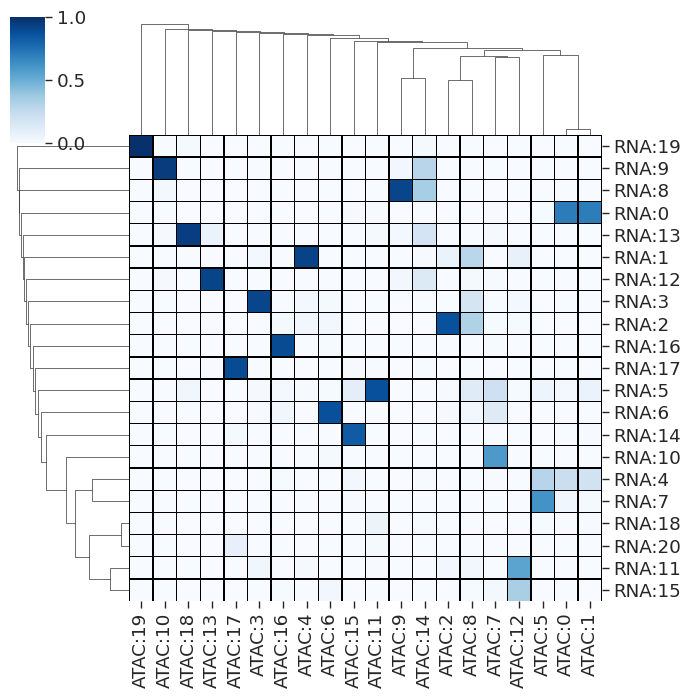

In [17]:
sns.clustermap(rna_by_atac, cmap=matplotlib.cm.Blues, vmin=0, vmax=1, 
               figsize=[7, 7], linecolor='black', linewidth=0.25, 
               row_cluster=True, col_cluster=True, 
               xticklabels=rna_by_atac.columns, yticklabels=rna_by_atac.index)

## Diffusion map comparison

NOTE: This is not necessarily relevant for PBMC data but added here for other datasets with continuous trajectories

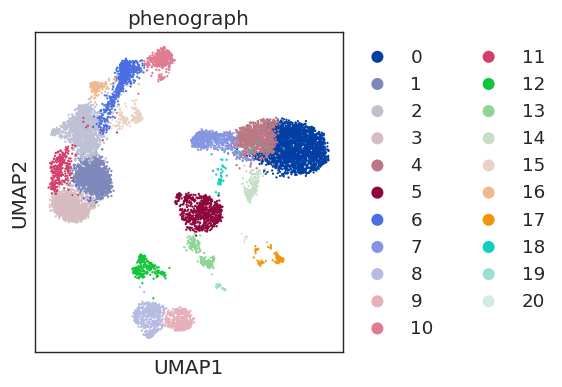

In [22]:
sc.pl.scatter(rna_ad, basis='umap', color='phenograph')

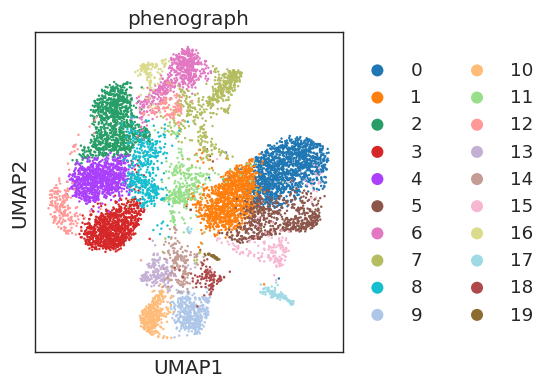

In [23]:
sc.pl.scatter(atac_ad, basis='umap', color='phenograph')

In [25]:
ct_colors = pd.Series(sns.color_palette(rna_ad.uns['phenograph_colors']).as_hex(), 
                     index=rna_ad.obs['phenograph'].values.categories)

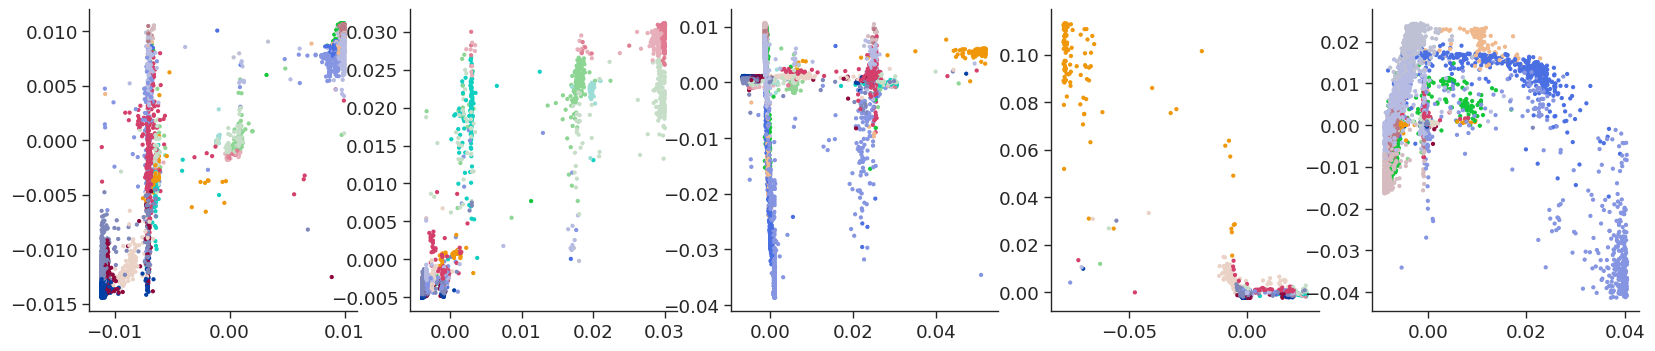

In [29]:
n_comps = 5

fig = palantir.plot.FigureGrid(n_comps, n_comps, scale=4)

for c, ax in enumerate(fig):
    ax.scatter(rna_ad[atac_ad.obs_names, :].obsm['DM_EigenVectors'][:, c + 1], 
              atac_ad.obsm['DM_EigenVectors'][:, c + 1], 
              s=5, color=ct_colors[atac_ad.obs['phenograph']])
sns.despine()